# ImageNet-Captions 50k

This notebook creates embeddings for the ImageNet-Captions 50k dataset using the CLIP prototyping experiments.

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

This dataset is created using a subset of ImageNet images that are from the 50 most frequent classes from the original validation set, with captions retrieved from the original Flickr posts. 

In [2]:
DATA_PATH = '/mnt/ssd/ronak/datasets/imagenet_captions_50k'
DEVICE = 'cuda:0'
NUM_CLASSES = 50

In [3]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "imagenet_captions_train_c50.csv"), header=0, sep="\t")
val_df = pd.read_csv(os.path.join(DATA_PATH, "imagenet_captions_val_c50.csv"), header=0, sep="\t")
class_df = pd.read_csv(os.path.join(DATA_PATH, "map_clsloc.txt"), sep=" ", header=None)

class_df.columns = ["directory", "class_idx", "class_name"]

In [4]:
train_df

,title,filepath
0,Books and coffee,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...
1,Sir Ian,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...
2,West 25 St bookstore,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...
3,Boris in the Bookshop,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...
4,QI Bookshop,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...
...,...,...
48241,"Asthall, Oxfordshire",/mnt/ssd/ronak/datasets/imagenet_captions_50k/...
48242,Postal Box Project 6,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...
48243,Letter Box Saviours,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...
48244,Esbenshade Turkey Farm Ronks Lancaster County ...,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...


In [5]:
class_df = class_df.set_index("directory")
class_df

,class_idx,class_name
directory,,
n02119789,1,kit_fox
n02100735,2,English_setter
n02110185,3,Siberian_husky
n02096294,4,Australian_terrier
n02102040,5,English_springer
...,...,...
n03063599,996,coffee_mug
n04116512,997,rubber_eraser
n04325704,998,stole


Confirm that the class labels match the folders correctly.

folder n02871525 corresponds to class bookshop.


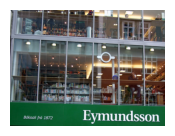

In [6]:
files = list(train_df['filepath'])
folder = os.path.split(files[0])[0].split("/")[-1]
class_name = class_df.loc[folder]['class_name']

print(f"folder {folder} corresponds to class {class_name}.")


img = mpimg.imread(files[0])

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

Our goal is to create data frames that contain the embeddings of the images using different models, embeddings of the captions, embeddings of the class names, and the list of class indices and names in natural language.

## Save Class Labels in Natural Language

In [7]:
def add_class_columns(df):
    df['directory'] = df['filepath'].map(lambda x: os.path.split(x)[0].split("/")[-1])
    df['class_name'] = df['directory'].map(lambda x: class_df.loc[x]['class_name'])
    df['class_idx'] = df['directory'].map(lambda x: class_df.loc[x]['class_idx'])
    return df

train_df = add_class_columns(train_df)
val_df = add_class_columns(val_df)

train_df

,title,filepath,directory,class_name,class_idx
0,Books and coffee,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n02871525,bookshop,706
1,Sir Ian,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n02871525,bookshop,706
2,West 25 St bookstore,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n02871525,bookshop,706
3,Boris in the Bookshop,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n02871525,bookshop,706
4,QI Bookshop,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n02871525,bookshop,706
...,...,...,...,...,...
48241,"Asthall, Oxfordshire",/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n03710193,mailbox,917
48242,Postal Box Project 6,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n03710193,mailbox,917
48243,Letter Box Saviours,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n03710193,mailbox,917
48244,Esbenshade Turkey Farm Ronks Lancaster County ...,/mnt/ssd/ronak/datasets/imagenet_captions_50k/...,n03710193,mailbox,917


In [8]:
train_class_labels = train_df[["class_name", "class_idx"]]
val_class_labels = val_df[["class_name", "class_idx"]]

train_class_labels.to_csv(os.path.join(DATA_PATH, "train_class_labels.txt"), sep="\t", index=False)
val_class_labels.to_csv(os.path.join(DATA_PATH, "val_class_labels.txt"), sep="\t", index=False)

## Create Image and Text Embeddings using CLIP ViT-B/32

Using [ViT-B/32](https://github.com/ronakdm/open_clip_dev/blob/main/docs/PRETRAINED.md) model trained on LAION-2B, which reaches an ImageNet top-1 zero-shot accuracy of 65.62%.

In [9]:
import open_clip
from training.data import get_data, CsvDataset
from training.params import parse_args
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

MODEL_NAME = "vit_b32_laion2b"

In [10]:
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.to(DEVICE)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

print("Log scale:", model.logit_scale)
print("Scale:", model.logit_scale.exp())

Log scale: Parameter containing:
tensor(4.6052, device='cuda:0', requires_grad=True)
Scale: tensor(100., device='cuda:0', grad_fn=<ExpBackward0>)


In [11]:
params = [
    "--train-data", f"{DATA_PATH}/imagenet_captions_train_c{NUM_CLASSES}.csv",
    "--val-data", f"{DATA_PATH}/imagenet_captions_val_c{NUM_CLASSES}.csv",
    "--dataset-type", "csv",
    "--csv-img-key", "filepath",
    "--csv-caption-key", "title"
]
args = parse_args(params)
args.distributed = False

In [12]:
# Create dataloader from scratch to not drop last
is_train = True
input_filename = args.train_data if is_train else args.val_data
assert input_filename
dataset = CsvDataset(
    input_filename,
    preprocess_train,
    img_key=args.csv_img_key,
    caption_key=args.csv_caption_key,
    sep=args.csv_separator,
    tokenizer=tokenizer,
)
num_samples = len(dataset)
sampler = DistributedSampler(dataset) if args.distributed and is_train else None
shuffle = is_train and sampler is None

dataloader = DataLoader(
    dataset,
    batch_size=args.batch_size,
    shuffle=shuffle,
    num_workers=args.workers,
    pin_memory=True,
    sampler=sampler,
    drop_last=False, # TODO: Changed from original
)
dataloader.num_samples = num_samples
dataloader.num_batches = len(dataloader)

Test that dataset order from dataloader agrees with original dataset order.

torch.Size([64, 3, 224, 224])
torch.Size([64, 77])


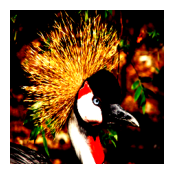

<start_of_text>crowned crane <end_of_text>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [23]:
for i, batch in enumerate(dataloader):
    idx, images, texts = batch
    break

print(images.shape)
print(texts.shape)

batch_id = 0

img = images[batch_id].numpy().transpose([1, 2, 0])
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

txt = texts[batch_id]
print(tokenizer.decode([elem.item() for elem in txt]))


In [25]:
if os.path.exists(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy")):
    print("found embeddings - loading...")
    all_image_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"))
    all_text_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"))
    all_idx = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"))
else:
    all_image_features, all_text_features, all_idx = [], [], []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            idx, images, texts = batch
            image_features = model.encode_image(images.to(DEVICE))
            text_features = model.encode_text(texts.to(DEVICE))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
            all_idx.append(idx)
            
    all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
    all_text_features = torch.cat(all_text_features).cpu().detach().numpy()
    all_idx = torch.cat(all_idx).cpu().detach().numpy()

    # Because the indices were random, we reorder them to be in line with the original dataset order.
    reorder = np.argsort(all_idx)
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"), all_image_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"), all_text_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"), all_idx[reorder])

print(all_image_features.shape)
print(all_text_features.shape)
print(all_idx.shape)

found embeddings - loading...
(48246, 512)
(48246, 512)
(48246,)


## Create Image Embeddings using ConvNeXt



## Create Text Embeddings using GloVe